In [41]:
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

train.shape, test.shape, submission.shape

((17480, 16), (15081, 15), (15081, 2))

In [42]:
# 결측치 확인

print(train.isna().sum())
print('===================================')
print(test.isna().sum())

id                   0
age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
target               0
dtype: int64
id                0
age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
dtype: int64


In [43]:
train.dropna(axis = 0, inplace = True)

train.isna().sum()

id                0
age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
target            0
dtype: int64

In [44]:
train.drop(['id'], axis = 1, inplace = True)
test.drop(['id'], axis = 1, inplace = True)

In [45]:
train.shape, test.shape

((15081, 15), (15081, 14))

In [46]:
X = train.drop(['target'], axis = 1)
y = train['target']

X.shape, test.shape

((15081, 14), (15081, 14))

In [47]:
# 스케일링

numeric_features = X.select_dtypes(exclude = 'object').columns
categorical_features = X.select_dtypes(include = 'object').columns

print(numeric_features)
print('===============================')
print(categorical_features)

Index(['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week'],
      dtype='object')
Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country'],
      dtype='object')


In [48]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

for obj in numeric_features:
    sc = RobustScaler()
    X[obj] = sc.fit_transform(X[[obj]])
    test[obj] = sc.fit_transform(test[[obj]])

In [49]:
for obj in categorical_features:
    le = LabelEncoder()
    X[obj] = le.fit_transform(X[obj])
    test[obj] = le.transform(test[obj])

In [50]:
X.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,-0.263158,2,1.089836,7,0.50,2,2,0,4,1,0.0,0.0,0.0,38
1,-0.210526,2,0.225984,15,0.00,2,3,0,4,1,0.0,0.0,0.0,38
2,0.473684,2,-0.234984,15,0.00,2,2,0,4,1,0.0,0.0,0.0,38
3,-0.736842,2,0.123205,9,0.75,4,0,3,4,0,0.0,0.0,-2.0,38
4,0.947368,2,-0.980206,11,-0.25,0,0,1,4,0,0.0,0.0,0.0,38


In [51]:
y.value_counts()

0    11308
1     3773
Name: target, dtype: int64

<BarContainer object of 2 artists>

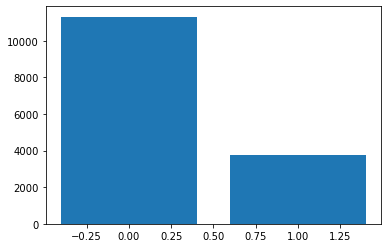

In [52]:
import matplotlib.pyplot as plt

plt.bar([0, 1], y.value_counts().to_numpy())

In [53]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

((12064, 14), (3017, 14), (12064,), (3017,))

In [54]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [55]:
def cat_objective(trial : Trial, X, y, test):
    
    param = {
        'iterations' : trial.suggest_int('iterations', 1000, 3000),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample' : trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'bagging_temperature' : trial.suggest_loguniform('bagging_temperature', 0.01, 0.1),
        
    }
    
    model = CatBoostClassifier(**param, verbose = 100)
    cat_model = model.fit(X_tr, y_tr)
    pred_cat = model.predict(X_val)
    score = accuracy_score(y_val, pred_cat)
    return score

In [56]:
cat_study = optuna.create_study(direction = 'maximize', sampler = TPESampler())
cat_study.optimize(lambda trial : cat_objective(trial, X_tr, y_tr, X_val), n_trials = 20)
print('Best trial : score {}, \nParams {}'.format(cat_study.best_trial.value, cat_study.best_trial.params))

[I 2022-04-23 15:04:05,517] A new study created in memory with name: no-name-d8e32f19-3fd5-4705-a280-d5b266bf2daf


0:	learn: 0.6853467	total: 14.6ms	remaining: 33s
100:	learn: 0.3826501	total: 962ms	remaining: 20.6s
200:	learn: 0.3358338	total: 1.98s	remaining: 20.3s
300:	learn: 0.3189343	total: 2.98s	remaining: 19.4s
400:	learn: 0.3092416	total: 3.97s	remaining: 18.4s
500:	learn: 0.3022585	total: 4.88s	remaining: 17.2s
600:	learn: 0.2971705	total: 5.82s	remaining: 16.1s
700:	learn: 0.2930601	total: 6.79s	remaining: 15.2s
800:	learn: 0.2892744	total: 7.72s	remaining: 14.1s
900:	learn: 0.2859153	total: 8.64s	remaining: 13.1s
1000:	learn: 0.2828084	total: 9.56s	remaining: 12.1s
1100:	learn: 0.2797301	total: 10.5s	remaining: 11.1s
1200:	learn: 0.2764299	total: 11.7s	remaining: 10.4s
1300:	learn: 0.2733966	total: 13s	remaining: 9.65s
1400:	learn: 0.2705079	total: 14.3s	remaining: 8.8s
1500:	learn: 0.2677482	total: 15.6s	remaining: 7.96s
1600:	learn: 0.2653540	total: 16.9s	remaining: 7.01s
1700:	learn: 0.2628403	total: 18.2s	remaining: 6.02s
1800:	learn: 0.2604467	total: 19.5s	remaining: 5.03s
1900:	lea

[I 2022-04-23 15:04:31,577] Trial 0 finished with value: 0.8531653960888299 and parameters: {'iterations': 2265, 'learning_rate': 0.008117455556493151, 'subsample': 0.6, 'bagging_temperature': 0.05926001389224838}. Best is trial 0 with value: 0.8531653960888299.


2264:	learn: 0.2500274	total: 25.4s	remaining: 0us
0:	learn: 0.6730785	total: 12.3ms	remaining: 21.3s
100:	learn: 0.3244009	total: 1.24s	remaining: 20s
200:	learn: 0.3011552	total: 2.51s	remaining: 19.2s
300:	learn: 0.2901737	total: 3.77s	remaining: 18s
400:	learn: 0.2817517	total: 5.07s	remaining: 16.9s
500:	learn: 0.2734689	total: 6.29s	remaining: 15.5s
600:	learn: 0.2659222	total: 7.55s	remaining: 14.3s
700:	learn: 0.2594393	total: 8.75s	remaining: 12.9s
800:	learn: 0.2536768	total: 9.97s	remaining: 11.7s
900:	learn: 0.2483617	total: 11.3s	remaining: 10.5s
1000:	learn: 0.2432869	total: 12.5s	remaining: 9.2s
1100:	learn: 0.2386704	total: 13.7s	remaining: 7.93s
1200:	learn: 0.2341518	total: 15s	remaining: 6.7s
1300:	learn: 0.2299818	total: 16.2s	remaining: 5.45s
1400:	learn: 0.2259567	total: 17.5s	remaining: 4.21s
1500:	learn: 0.2221070	total: 18.7s	remaining: 2.95s
1600:	learn: 0.2183661	total: 19.9s	remaining: 1.71s
1700:	learn: 0.2147890	total: 21.2s	remaining: 462ms


[I 2022-04-23 15:04:53,832] Trial 1 finished with value: 0.8558170367915148 and parameters: {'iterations': 1738, 'learning_rate': 0.021147524050778823, 'subsample': 0.6, 'bagging_temperature': 0.07326840087907442}. Best is trial 1 with value: 0.8558170367915148.


1737:	learn: 0.2134579	total: 21.7s	remaining: 0us
0:	learn: 0.6812258	total: 26.8ms	remaining: 46.7s
100:	learn: 0.3501210	total: 1.3s	remaining: 21.2s
200:	learn: 0.3171769	total: 2.52s	remaining: 19.3s
300:	learn: 0.3042665	total: 3.69s	remaining: 17.7s
400:	learn: 0.2959409	total: 4.87s	remaining: 16.3s
500:	learn: 0.2896625	total: 6.17s	remaining: 15.3s
600:	learn: 0.2841445	total: 7.42s	remaining: 14.1s
700:	learn: 0.2794233	total: 8.69s	remaining: 12.9s
800:	learn: 0.2740808	total: 9.89s	remaining: 11.6s
900:	learn: 0.2693244	total: 11.1s	remaining: 10.4s
1000:	learn: 0.2646644	total: 12.3s	remaining: 9.14s
1100:	learn: 0.2606145	total: 13.5s	remaining: 7.88s
1200:	learn: 0.2569034	total: 14.8s	remaining: 6.68s
1300:	learn: 0.2532713	total: 16.1s	remaining: 5.47s
1400:	learn: 0.2499037	total: 17.3s	remaining: 4.23s
1500:	learn: 0.2468770	total: 18.5s	remaining: 3s
1600:	learn: 0.2438524	total: 19.8s	remaining: 1.77s
1700:	learn: 0.2411872	total: 21.1s	remaining: 534ms


[I 2022-04-23 15:05:16,114] Trial 2 finished with value: 0.8554855817036792 and parameters: {'iterations': 1744, 'learning_rate': 0.012785417084246591, 'subsample': 1.0, 'bagging_temperature': 0.04095636553564794}. Best is trial 1 with value: 0.8558170367915148.


1743:	learn: 0.2398637	total: 21.7s	remaining: 0us
0:	learn: 0.6918078	total: 20ms	remaining: 26.4s
100:	learn: 0.5826212	total: 1.36s	remaining: 16.5s
200:	learn: 0.5085790	total: 2.74s	remaining: 15.3s
300:	learn: 0.4577810	total: 4.02s	remaining: 13.6s
400:	learn: 0.4236357	total: 5.37s	remaining: 12.3s
500:	learn: 0.3991157	total: 6.7s	remaining: 10.9s
600:	learn: 0.3814852	total: 7.99s	remaining: 9.56s
700:	learn: 0.3685123	total: 9.32s	remaining: 8.23s
800:	learn: 0.3583830	total: 10.6s	remaining: 6.89s
900:	learn: 0.3507913	total: 12s	remaining: 5.56s
1000:	learn: 0.3445391	total: 13.4s	remaining: 4.26s
1100:	learn: 0.3392013	total: 14.7s	remaining: 2.92s
1200:	learn: 0.3347932	total: 16s	remaining: 1.59s
1300:	learn: 0.3310640	total: 17.4s	remaining: 254ms


[I 2022-04-23 15:05:34,221] Trial 3 finished with value: 0.8435531985415976 and parameters: {'iterations': 1320, 'learning_rate': 0.0013848417035555091, 'subsample': 0.8, 'bagging_temperature': 0.0807236568553721}. Best is trial 1 with value: 0.8558170367915148.


1319:	learn: 0.3304341	total: 17.7s	remaining: 0us
0:	learn: 0.6462664	total: 23.7ms	remaining: 34.1s
100:	learn: 0.2953770	total: 1.36s	remaining: 18s
200:	learn: 0.2736235	total: 2.73s	remaining: 16.8s
300:	learn: 0.2567650	total: 4.23s	remaining: 16s
400:	learn: 0.2435528	total: 5.74s	remaining: 14.9s
500:	learn: 0.2320723	total: 7.21s	remaining: 13.5s
600:	learn: 0.2223381	total: 8.66s	remaining: 12.1s
700:	learn: 0.2128362	total: 9.96s	remaining: 10.5s
800:	learn: 0.2042775	total: 11.3s	remaining: 9s
900:	learn: 0.1965299	total: 12.7s	remaining: 7.59s
1000:	learn: 0.1892649	total: 14.2s	remaining: 6.24s
1100:	learn: 0.1828130	total: 15.7s	remaining: 4.83s
1200:	learn: 0.1767785	total: 17s	remaining: 3.38s
1300:	learn: 0.1703754	total: 18.4s	remaining: 1.97s
1400:	learn: 0.1646518	total: 20s	remaining: 557ms


[I 2022-04-23 15:05:55,515] Trial 4 finished with value: 0.851508120649652 and parameters: {'iterations': 1440, 'learning_rate': 0.052195558909209544, 'subsample': 1.0, 'bagging_temperature': 0.07432751252765357}. Best is trial 1 with value: 0.8558170367915148.


1439:	learn: 0.1626490	total: 20.7s	remaining: 0us
0:	learn: 0.6898801	total: 25.4ms	remaining: 33.2s
100:	learn: 0.4815735	total: 2.32s	remaining: 27.6s
200:	learn: 0.4011648	total: 4.43s	remaining: 24.4s
300:	learn: 0.3653792	total: 6.36s	remaining: 21.2s
400:	learn: 0.3462417	total: 8.15s	remaining: 18.4s
500:	learn: 0.3341927	total: 9.81s	remaining: 15.8s
600:	learn: 0.3258486	total: 11.4s	remaining: 13.3s
700:	learn: 0.3198319	total: 12.8s	remaining: 11s
800:	learn: 0.3149979	total: 14.3s	remaining: 8.98s
900:	learn: 0.3111425	total: 15.7s	remaining: 7.05s
1000:	learn: 0.3077585	total: 17.1s	remaining: 5.21s
1100:	learn: 0.3048336	total: 18.6s	remaining: 3.45s
1200:	learn: 0.3022570	total: 20.1s	remaining: 1.74s


[I 2022-04-23 15:06:17,660] Trial 5 finished with value: 0.8468677494199536 and parameters: {'iterations': 1305, 'learning_rate': 0.003384506995037152, 'subsample': 0.7, 'bagging_temperature': 0.09337001344424001}. Best is trial 1 with value: 0.8558170367915148.


1300:	learn: 0.3000177	total: 21.6s	remaining: 66.3ms
1304:	learn: 0.2999252	total: 21.6s	remaining: 0us
0:	learn: 0.6919254	total: 14.4ms	remaining: 23.5s
100:	learn: 0.5909536	total: 1.39s	remaining: 21.1s
200:	learn: 0.5197935	total: 2.85s	remaining: 20.3s
300:	learn: 0.4699624	total: 4.36s	remaining: 19.3s
400:	learn: 0.4342907	total: 5.81s	remaining: 17.8s
500:	learn: 0.4087055	total: 7.35s	remaining: 16.6s
600:	learn: 0.3901624	total: 8.85s	remaining: 15.2s
700:	learn: 0.3761740	total: 10.3s	remaining: 13.7s
800:	learn: 0.3654465	total: 11.8s	remaining: 12.2s
900:	learn: 0.3568752	total: 13.2s	remaining: 10.7s
1000:	learn: 0.3499638	total: 14.6s	remaining: 9.18s
1100:	learn: 0.3442121	total: 16s	remaining: 7.72s
1200:	learn: 0.3394192	total: 17.5s	remaining: 6.28s
1300:	learn: 0.3352796	total: 18.9s	remaining: 4.8s
1400:	learn: 0.3316798	total: 20.4s	remaining: 3.36s
1500:	learn: 0.3287153	total: 21.8s	remaining: 1.9s
1600:	learn: 0.3260254	total: 23.4s	remaining: 453ms


[I 2022-04-23 15:06:42,121] Trial 6 finished with value: 0.8455419290686113 and parameters: {'iterations': 1632, 'learning_rate': 0.0012631467318145434, 'subsample': 0.7, 'bagging_temperature': 0.09696998044408361}. Best is trial 1 with value: 0.8558170367915148.


1631:	learn: 0.3251978	total: 23.9s	remaining: 0us
0:	learn: 0.6856625	total: 14.5ms	remaining: 20.2s
100:	learn: 0.3861137	total: 1.41s	remaining: 18.2s
200:	learn: 0.3379324	total: 2.84s	remaining: 16.9s
300:	learn: 0.3206022	total: 4.43s	remaining: 16.2s
400:	learn: 0.3106472	total: 5.86s	remaining: 14.6s
500:	learn: 0.3035821	total: 7.36s	remaining: 13.2s
600:	learn: 0.2983638	total: 8.85s	remaining: 11.8s
700:	learn: 0.2941034	total: 10.3s	remaining: 10.3s
800:	learn: 0.2903458	total: 11.7s	remaining: 8.76s
900:	learn: 0.2869742	total: 13.3s	remaining: 7.36s
1000:	learn: 0.2838036	total: 14.7s	remaining: 5.88s
1100:	learn: 0.2809039	total: 16.2s	remaining: 4.42s
1200:	learn: 0.2780284	total: 17.8s	remaining: 2.96s
1300:	learn: 0.2751405	total: 19.2s	remaining: 1.48s


[I 2022-04-23 15:07:03,338] Trial 7 finished with value: 0.8495193901226383 and parameters: {'iterations': 1401, 'learning_rate': 0.007786361071016957, 'subsample': 0.6, 'bagging_temperature': 0.03642250872417184}. Best is trial 1 with value: 0.8558170367915148.


1400:	learn: 0.2722237	total: 20.7s	remaining: 0us
0:	learn: 0.6766107	total: 25.3ms	remaining: 34.4s
100:	learn: 0.3316132	total: 1.57s	remaining: 19.6s
200:	learn: 0.3060959	total: 3.21s	remaining: 18.5s
300:	learn: 0.2940960	total: 4.61s	remaining: 16.2s
400:	learn: 0.2855700	total: 6.15s	remaining: 14.7s
500:	learn: 0.2790847	total: 7.68s	remaining: 13.2s
600:	learn: 0.2719728	total: 9.2s	remaining: 11.6s
700:	learn: 0.2649241	total: 10.6s	remaining: 10s
800:	learn: 0.2594572	total: 12.2s	remaining: 8.52s
900:	learn: 0.2544404	total: 13.6s	remaining: 6.96s
1000:	learn: 0.2500497	total: 15.2s	remaining: 5.46s
1100:	learn: 0.2458764	total: 16.6s	remaining: 3.93s
1200:	learn: 0.2417071	total: 18.1s	remaining: 2.41s
1300:	learn: 0.2378019	total: 19.8s	remaining: 915ms


[I 2022-04-23 15:07:24,689] Trial 8 finished with value: 0.8571428571428571 and parameters: {'iterations': 1361, 'learning_rate': 0.017818783448294562, 'subsample': 1.0, 'bagging_temperature': 0.06954258871036993}. Best is trial 8 with value: 0.8571428571428571.


1360:	learn: 0.2354190	total: 20.8s	remaining: 0us
0:	learn: 0.6887991	total: 17ms	remaining: 50.5s
100:	learn: 0.4469714	total: 1.73s	remaining: 49s
200:	learn: 0.3745820	total: 3.37s	remaining: 46.5s
300:	learn: 0.3457234	total: 4.87s	remaining: 43.2s
400:	learn: 0.3306801	total: 6.54s	remaining: 41.9s
500:	learn: 0.3212161	total: 8.26s	remaining: 40.7s
600:	learn: 0.3147452	total: 9.95s	remaining: 39.2s
700:	learn: 0.3097281	total: 11.5s	remaining: 37.1s
800:	learn: 0.3055113	total: 13.1s	remaining: 35.3s
900:	learn: 0.3019868	total: 14.7s	remaining: 33.7s
1000:	learn: 0.2989872	total: 16.3s	remaining: 32.1s
1100:	learn: 0.2962093	total: 17.9s	remaining: 30.4s
1200:	learn: 0.2936734	total: 19.5s	remaining: 28.6s
1300:	learn: 0.2914701	total: 21s	remaining: 26.9s
1400:	learn: 0.2894624	total: 22.6s	remaining: 25.3s
1500:	learn: 0.2874523	total: 24.2s	remaining: 23.7s
1600:	learn: 0.2856642	total: 25.8s	remaining: 22s
1700:	learn: 0.2839218	total: 27.5s	remaining: 20.5s
1800:	learn: 0

[I 2022-04-23 15:08:14,155] Trial 9 finished with value: 0.8511766655618164 and parameters: {'iterations': 2969, 'learning_rate': 0.004509157992814141, 'subsample': 0.8, 'bagging_temperature': 0.04662327161504997}. Best is trial 8 with value: 0.8571428571428571.


2968:	learn: 0.2629444	total: 48.3s	remaining: 0us
0:	learn: 0.6154451	total: 22.7ms	remaining: 23.2s
100:	learn: 0.2785458	total: 1.72s	remaining: 15.7s
200:	learn: 0.2491882	total: 3.34s	remaining: 13.6s
300:	learn: 0.2292056	total: 4.99s	remaining: 11.9s
400:	learn: 0.2130505	total: 6.7s	remaining: 10.4s
500:	learn: 0.1988978	total: 8.33s	remaining: 8.64s
600:	learn: 0.1865040	total: 9.94s	remaining: 6.94s
700:	learn: 0.1764855	total: 11.7s	remaining: 5.32s
800:	learn: 0.1669546	total: 13.3s	remaining: 3.67s
900:	learn: 0.1575069	total: 15s	remaining: 1.99s
1000:	learn: 0.1490286	total: 16.7s	remaining: 334ms


[I 2022-04-23 15:08:31,676] Trial 10 finished with value: 0.8544912164401723 and parameters: {'iterations': 1021, 'learning_rate': 0.0897499874602183, 'subsample': 1.0, 'bagging_temperature': 0.018831658009168792}. Best is trial 8 with value: 0.8571428571428571.


1020:	learn: 0.1473329	total: 17s	remaining: 0us
0:	learn: 0.6692235	total: 18.6ms	remaining: 39.3s
100:	learn: 0.3174272	total: 1.87s	remaining: 37.2s
200:	learn: 0.2962955	total: 3.57s	remaining: 34s
300:	learn: 0.2852700	total: 5.19s	remaining: 31.3s
400:	learn: 0.2754257	total: 6.92s	remaining: 29.6s
500:	learn: 0.2659283	total: 8.74s	remaining: 28.2s
600:	learn: 0.2582041	total: 10.4s	remaining: 26.2s
700:	learn: 0.2511358	total: 12.1s	remaining: 24.3s
800:	learn: 0.2451151	total: 13.9s	remaining: 22.8s
900:	learn: 0.2394086	total: 15.5s	remaining: 20.9s
1000:	learn: 0.2340221	total: 17.2s	remaining: 19.1s
1100:	learn: 0.2291250	total: 18.9s	remaining: 17.4s
1200:	learn: 0.2245521	total: 20.5s	remaining: 15.6s
1300:	learn: 0.2198429	total: 22.4s	remaining: 14s
1400:	learn: 0.2157893	total: 24.1s	remaining: 12.3s
1500:	learn: 0.2117013	total: 25.8s	remaining: 10.6s
1600:	learn: 0.2077457	total: 27.6s	remaining: 8.89s
1700:	learn: 0.2036969	total: 29.4s	remaining: 7.17s
1800:	learn:

[I 2022-04-23 15:09:08,982] Trial 11 finished with value: 0.8571428571428571 and parameters: {'iterations': 2116, 'learning_rate': 0.02531178270491443, 'subsample': 0.6, 'bagging_temperature': 0.022481113803140388}. Best is trial 8 with value: 0.8571428571428571.


2115:	learn: 0.1893424	total: 36.4s	remaining: 0us
0:	learn: 0.6669065	total: 15.7ms	remaining: 35.6s
100:	learn: 0.3133134	total: 1.7s	remaining: 36.5s
200:	learn: 0.2929721	total: 3.32s	remaining: 34.2s
300:	learn: 0.2805504	total: 5.06s	remaining: 33.1s
400:	learn: 0.2686749	total: 6.72s	remaining: 31.3s
500:	learn: 0.2592746	total: 8.34s	remaining: 29.4s
600:	learn: 0.2516106	total: 9.95s	remaining: 27.6s
700:	learn: 0.2446396	total: 11.8s	remaining: 26.3s
800:	learn: 0.2384327	total: 13.5s	remaining: 24.8s
900:	learn: 0.2328157	total: 15.2s	remaining: 23.1s
1000:	learn: 0.2271209	total: 16.9s	remaining: 21.4s
1100:	learn: 0.2217502	total: 18.7s	remaining: 19.8s
1200:	learn: 0.2164007	total: 20.5s	remaining: 18.3s
1300:	learn: 0.2117410	total: 22.2s	remaining: 16.5s
1400:	learn: 0.2071478	total: 23.9s	remaining: 14.8s
1500:	learn: 0.2030986	total: 25.6s	remaining: 13.1s
1600:	learn: 0.1989732	total: 27.3s	remaining: 11.4s
1700:	learn: 0.1947663	total: 28.9s	remaining: 9.66s
1800:	l

[I 2022-04-23 15:09:48,463] Trial 12 finished with value: 0.8554855817036792 and parameters: {'iterations': 2270, 'learning_rate': 0.028563043008236783, 'subsample': 1.0, 'bagging_temperature': 0.020616452391510293}. Best is trial 8 with value: 0.8571428571428571.


2269:	learn: 0.1742403	total: 38.5s	remaining: 0us
0:	learn: 0.6648720	total: 19.4ms	remaining: 44.1s
100:	learn: 0.3113053	total: 1.68s	remaining: 36.1s
200:	learn: 0.2908948	total: 3.54s	remaining: 36.5s
300:	learn: 0.2799063	total: 5.36s	remaining: 35.1s
400:	learn: 0.2681361	total: 7.13s	remaining: 33.3s
500:	learn: 0.2591721	total: 8.95s	remaining: 31.7s
600:	learn: 0.2509762	total: 10.6s	remaining: 29.6s
700:	learn: 0.2435222	total: 12.4s	remaining: 27.9s
800:	learn: 0.2366665	total: 14.2s	remaining: 26.1s
900:	learn: 0.2305534	total: 15.8s	remaining: 24s
1000:	learn: 0.2245898	total: 17.5s	remaining: 22.2s
1100:	learn: 0.2191660	total: 19.1s	remaining: 20.4s
1200:	learn: 0.2142950	total: 20.8s	remaining: 18.6s
1300:	learn: 0.2092683	total: 22.5s	remaining: 16.9s
1400:	learn: 0.2047492	total: 24.3s	remaining: 15.1s
1500:	learn: 0.2003212	total: 25.9s	remaining: 13.3s
1600:	learn: 0.1963755	total: 27.5s	remaining: 11.5s
1700:	learn: 0.1920833	total: 29s	remaining: 9.78s
1800:	lear

[I 2022-04-23 15:10:28,130] Trial 13 finished with value: 0.8544912164401723 and parameters: {'iterations': 2274, 'learning_rate': 0.03005419152092793, 'subsample': 0.6, 'bagging_temperature': 0.010124141413480146}. Best is trial 8 with value: 0.8571428571428571.


2273:	learn: 0.1718631	total: 38.7s	remaining: 0us
0:	learn: 0.6745734	total: 15ms	remaining: 40.9s
100:	learn: 0.3269096	total: 1.58s	remaining: 41.1s
200:	learn: 0.3019028	total: 3.31s	remaining: 41.8s
300:	learn: 0.2899993	total: 5.08s	remaining: 41.1s
400:	learn: 0.2816400	total: 6.79s	remaining: 39.6s
500:	learn: 0.2743643	total: 8.42s	remaining: 37.6s
600:	learn: 0.2667625	total: 10.2s	remaining: 36.3s
700:	learn: 0.2600086	total: 12s	remaining: 34.8s
800:	learn: 0.2543143	total: 13.8s	remaining: 33.3s
900:	learn: 0.2492814	total: 15.5s	remaining: 31.6s
1000:	learn: 0.2446899	total: 17.2s	remaining: 29.9s
1100:	learn: 0.2404080	total: 18.9s	remaining: 28.1s
1200:	learn: 0.2359619	total: 20.7s	remaining: 26.5s
1300:	learn: 0.2318529	total: 22.4s	remaining: 24.7s
1400:	learn: 0.2279285	total: 24s	remaining: 22.9s
1500:	learn: 0.2240815	total: 25.8s	remaining: 21.3s
1600:	learn: 0.2203217	total: 27.6s	remaining: 19.6s
1700:	learn: 0.2167383	total: 29.4s	remaining: 17.9s
1800:	learn:

[I 2022-04-23 15:11:16,342] Trial 14 finished with value: 0.8551541266158436 and parameters: {'iterations': 2737, 'learning_rate': 0.02005614179436446, 'subsample': 1.0, 'bagging_temperature': 0.02318609971148439}. Best is trial 8 with value: 0.8571428571428571.


2736:	learn: 0.1867672	total: 47.1s	remaining: 0us
0:	learn: 0.6457380	total: 15.8ms	remaining: 31.8s
100:	learn: 0.2953151	total: 1.8s	remaining: 34.2s
200:	learn: 0.2749303	total: 3.39s	remaining: 30.6s
300:	learn: 0.2575234	total: 4.95s	remaining: 28.2s
400:	learn: 0.2445105	total: 6.67s	remaining: 26.9s
500:	learn: 0.2325776	total: 8.27s	remaining: 25s
600:	learn: 0.2227813	total: 9.98s	remaining: 23.5s
700:	learn: 0.2135101	total: 11.8s	remaining: 22.1s
800:	learn: 0.2053126	total: 13.4s	remaining: 20.4s
900:	learn: 0.1977099	total: 15.2s	remaining: 18.8s
1000:	learn: 0.1903949	total: 16.8s	remaining: 17.1s
1100:	learn: 0.1839033	total: 18.4s	remaining: 15.3s
1200:	learn: 0.1784039	total: 20s	remaining: 13.6s
1300:	learn: 0.1722938	total: 21.7s	remaining: 11.9s
1400:	learn: 0.1673564	total: 23.4s	remaining: 10.3s
1500:	learn: 0.1620155	total: 25.2s	remaining: 8.67s
1600:	learn: 0.1570403	total: 27.1s	remaining: 7.04s
1700:	learn: 0.1523182	total: 28.8s	remaining: 5.35s
1800:	learn

[I 2022-04-23 15:11:51,232] Trial 15 finished with value: 0.8508452104739808 and parameters: {'iterations': 2017, 'learning_rate': 0.05146494066571563, 'subsample': 0.6, 'bagging_temperature': 0.02808852051707518}. Best is trial 8 with value: 0.8571428571428571.


2016:	learn: 0.1390472	total: 34s	remaining: 0us
0:	learn: 0.6807675	total: 16.9ms	remaining: 33.8s
100:	learn: 0.3479081	total: 1.71s	remaining: 32.2s
200:	learn: 0.3159333	total: 3.52s	remaining: 31.5s
300:	learn: 0.3032677	total: 5.21s	remaining: 29.4s
400:	learn: 0.2950310	total: 6.88s	remaining: 27.5s
500:	learn: 0.2888747	total: 8.49s	remaining: 25.4s
600:	learn: 0.2837305	total: 10.3s	remaining: 24s
700:	learn: 0.2789425	total: 12s	remaining: 22.2s
800:	learn: 0.2737581	total: 13.7s	remaining: 20.4s
900:	learn: 0.2688812	total: 15.5s	remaining: 18.9s
1000:	learn: 0.2647232	total: 17.2s	remaining: 17.2s
1100:	learn: 0.2606464	total: 19.1s	remaining: 15.6s
1200:	learn: 0.2569824	total: 20.8s	remaining: 13.8s
1300:	learn: 0.2535811	total: 22.6s	remaining: 12.1s
1400:	learn: 0.2502540	total: 24.3s	remaining: 10.4s
1500:	learn: 0.2469811	total: 26s	remaining: 8.65s
1600:	learn: 0.2439947	total: 27.8s	remaining: 6.93s
1700:	learn: 0.2410680	total: 29.5s	remaining: 5.19s
1800:	learn: 0

[I 2022-04-23 15:12:26,662] Trial 16 finished with value: 0.8554855817036792 and parameters: {'iterations': 2000, 'learning_rate': 0.012942479873940533, 'subsample': 0.7, 'bagging_temperature': 0.01383116325094504}. Best is trial 8 with value: 0.8571428571428571.


1999:	learn: 0.2327552	total: 34.6s	remaining: 0us
0:	learn: 0.6478816	total: 18.1ms	remaining: 18.1s
100:	learn: 0.2977030	total: 1.71s	remaining: 15.2s
200:	learn: 0.2760661	total: 3.32s	remaining: 13.2s
300:	learn: 0.2589059	total: 5.16s	remaining: 12s
400:	learn: 0.2461893	total: 7s	remaining: 10.5s
500:	learn: 0.2350247	total: 8.7s	remaining: 8.68s
600:	learn: 0.2258654	total: 10.4s	remaining: 6.89s
700:	learn: 0.2168753	total: 12s	remaining: 5.14s
800:	learn: 0.2089529	total: 13.6s	remaining: 3.4s
900:	learn: 0.2017527	total: 15.4s	remaining: 1.71s


[I 2022-04-23 15:12:44,286] Trial 17 finished with value: 0.8554855817036792 and parameters: {'iterations': 1001, 'learning_rate': 0.049018897637289935, 'subsample': 0.8, 'bagging_temperature': 0.054523959931620146}. Best is trial 8 with value: 0.8571428571428571.


1000:	learn: 0.1942520	total: 17.2s	remaining: 0us
0:	learn: 0.6885367	total: 16.1ms	remaining: 41.4s
100:	learn: 0.4391481	total: 1.83s	remaining: 44.7s
200:	learn: 0.3690511	total: 3.48s	remaining: 41.1s
300:	learn: 0.3427896	total: 5.23s	remaining: 39.5s
400:	learn: 0.3286594	total: 6.84s	remaining: 37s
500:	learn: 0.3198619	total: 8.57s	remaining: 35.5s
600:	learn: 0.3133954	total: 10.2s	remaining: 33.6s
700:	learn: 0.3085365	total: 11.8s	remaining: 31.6s
800:	learn: 0.3045520	total: 13.5s	remaining: 29.9s
900:	learn: 0.3010094	total: 15.3s	remaining: 28.4s
1000:	learn: 0.2979722	total: 17.1s	remaining: 26.8s
1100:	learn: 0.2952665	total: 18.7s	remaining: 25.1s
1200:	learn: 0.2928043	total: 20.3s	remaining: 23.2s
1300:	learn: 0.2905796	total: 22s	remaining: 21.5s
1400:	learn: 0.2885542	total: 23.7s	remaining: 19.8s
1500:	learn: 0.2865307	total: 25.3s	remaining: 18s
1600:	learn: 0.2847673	total: 26.9s	remaining: 16.4s
1700:	learn: 0.2828382	total: 28.6s	remaining: 14.7s
1800:	learn:

[I 2022-04-23 15:13:28,010] Trial 18 finished with value: 0.8498508452104739 and parameters: {'iterations': 2573, 'learning_rate': 0.004782562396390391, 'subsample': 0.6, 'bagging_temperature': 0.029467733370887282}. Best is trial 8 with value: 0.8571428571428571.


2572:	learn: 0.2670909	total: 42.7s	remaining: 0us
0:	learn: 0.6787159	total: 16.4ms	remaining: 41s
100:	learn: 0.3391632	total: 1.58s	remaining: 37.6s
200:	learn: 0.3110080	total: 3.17s	remaining: 36.3s
300:	learn: 0.2983350	total: 4.92s	remaining: 35.9s
400:	learn: 0.2900196	total: 6.63s	remaining: 34.7s
500:	learn: 0.2835585	total: 8.27s	remaining: 33s
600:	learn: 0.2775165	total: 9.84s	remaining: 31.1s
700:	learn: 0.2711142	total: 11.4s	remaining: 29.2s
800:	learn: 0.2656769	total: 13s	remaining: 27.6s
900:	learn: 0.2607405	total: 14.7s	remaining: 26.2s
1000:	learn: 0.2560892	total: 16.5s	remaining: 24.8s
1100:	learn: 0.2520712	total: 18.3s	remaining: 23.3s
1200:	learn: 0.2483521	total: 19.9s	remaining: 21.6s
1300:	learn: 0.2449436	total: 21.5s	remaining: 19.8s
1400:	learn: 0.2415128	total: 23.1s	remaining: 18.1s
1500:	learn: 0.2381009	total: 24.7s	remaining: 16.5s
1600:	learn: 0.2347184	total: 26.5s	remaining: 14.9s
1700:	learn: 0.2314894	total: 28.2s	remaining: 13.2s
1800:	learn:

[I 2022-04-23 15:14:10,683] Trial 19 finished with value: 0.8588001325820351 and parameters: {'iterations': 2501, 'learning_rate': 0.015516836179637134, 'subsample': 1.0, 'bagging_temperature': 0.017746272461070425}. Best is trial 19 with value: 0.8588001325820351.


2500:	learn: 0.2093380	total: 41.6s	remaining: 0us
Best trial : score 0.8588001325820351, 
Params {'iterations': 2501, 'learning_rate': 0.015516836179637134, 'subsample': 1.0, 'bagging_temperature': 0.017746272461070425}


In [57]:
def lgbm_objective(trial : Trial, X, y, test):
    
    param = {
        'num_leaves' : trial.suggest_int('num_leaves', 10, 50),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample' : trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'n_estimators' : trial.suggest_int('n_estimators', 10, 100)
    }
    
    model = LGBMClassifier(**param)
    lgbm_model = model.fit(X_tr, y_tr)
    pred_lgbm = model.predict(X_val)
    score = accuracy_score(y_val, pred_lgbm)
    return score

In [58]:
lgbm_study = optuna.create_study(direction = 'maximize', sampler = TPESampler())
lgbm_study.optimize(lambda trial : lgbm_objective(trial, X_tr, y_tr, X_val), n_trials = 20)
print('Best trial : score {}, \nParams {}'.format(lgbm_study.best_trial.value, lgbm_study.best_trial.params))

[I 2022-04-23 15:14:10,721] A new study created in memory with name: no-name-1f095886-3003-4057-9669-0c37bbda24db
[I 2022-04-23 15:14:11,172] Trial 0 finished with value: 0.7497514086841233 and parameters: {'num_leaves': 29, 'learning_rate': 0.002288264733349076, 'subsample': 0.7, 'n_estimators': 72}. Best is trial 0 with value: 0.7497514086841233.
[I 2022-04-23 15:14:11,670] Trial 1 finished with value: 0.8438846536294332 and parameters: {'num_leaves': 34, 'learning_rate': 0.012342764951542354, 'subsample': 0.7, 'n_estimators': 76}. Best is trial 1 with value: 0.8438846536294332.
[I 2022-04-23 15:14:12,050] Trial 2 finished with value: 0.7497514086841233 and parameters: {'num_leaves': 16, 'learning_rate': 0.0031989891895677224, 'subsample': 0.7, 'n_estimators': 93}. Best is trial 1 with value: 0.8438846536294332.
[I 2022-04-23 15:14:12,280] Trial 3 finished with value: 0.7497514086841233 and parameters: {'num_leaves': 45, 'learning_rate': 0.0010319449193421982, 'subsample': 0.7, 'n_es

Best trial : score 0.8544912164401723, 
Params {'num_leaves': 50, 'learning_rate': 0.09141403977651523, 'subsample': 0.6, 'n_estimators': 45}


In [59]:
from xgboost import XGBClassifier

def xgb_objective(trial : Trial, X, y, test):
    
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
        'max_depth' : trial.suggest_int('max_depth', 1, 16),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 20),
        'learning_rate' : trial.suggest_uniform('learning_rate', 0.001, 0.1),
        'colsample_bytree' : trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1),
        'subsample' : trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'random_state' : 42
        }
    
    model = XGBClassifier(**param)
    xgb_model = model.fit(X_tr, y_tr)
    pred_xgb = model.predict(X_val)
    score = accuracy_score(y_val, pred_xgb)
    return score

In [60]:
xgb_study = optuna.create_study(direction = 'maximize', sampler = TPESampler())
xgb_study.optimize(lambda trial : xgb_objective(trial, X_tr, y_tr, X_val), n_trials = 20)
print('Best trial : score {}, \nParams {}'.format(xgb_study.best_trial.value, xgb_study.best_trial.params))

[I 2022-04-23 15:14:17,875] A new study created in memory with name: no-name-fdb038ce-6f4d-4a0e-9ad8-747fb7f6100d
[I 2022-04-23 15:14:32,781] Trial 0 finished with value: 0.8402386476632416 and parameters: {'n_estimators': 868, 'max_depth': 13, 'min_child_weight': 7, 'learning_rate': 0.09683834789171027, 'colsample_bytree': 0.5, 'subsample': 0.7}. Best is trial 0 with value: 0.8402386476632416.
[I 2022-04-23 15:14:38,768] Trial 1 finished with value: 0.8568114020550216 and parameters: {'n_estimators': 647, 'max_depth': 5, 'min_child_weight': 12, 'learning_rate': 0.03710108090837636, 'colsample_bytree': 0.9, 'subsample': 1.0}. Best is trial 1 with value: 0.8568114020550216.
[I 2022-04-23 15:14:44,914] Trial 2 finished with value: 0.8468677494199536 and parameters: {'n_estimators': 332, 'max_depth': 16, 'min_child_weight': 9, 'learning_rate': 0.08497141570340362, 'colsample_bytree': 0.6, 'subsample': 0.6}. Best is trial 1 with value: 0.8568114020550216.
[I 2022-04-23 15:14:51,305] Trial 

Best trial : score 0.859794497845542, 
Params {'n_estimators': 618, 'max_depth': 6, 'min_child_weight': 5, 'learning_rate': 0.05195207270334887, 'colsample_bytree': 0.7, 'subsample': 1.0}


In [61]:
from sklearn.ensemble import GradientBoostingClassifier

def gbr_objective(trial : Trial, X, y, test):
    
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
        'max_depth' : trial.suggest_int('max_depth', 1, 16),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample' : trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'random_state' : 42
        }
    
    model = GradientBoostingClassifier(**param)
    gbr_model = model.fit(X_tr, y_tr)
    pred_gbr = model.predict(X_val)
    score = accuracy_score(y_val, pred_gbr)
    return score

In [62]:
gbr_study = optuna.create_study(direction = 'maximize', sampler = TPESampler())
gbr_study.optimize(lambda trial : gbr_objective(trial, X_tr, y_tr, X_val), n_trials = 20)
print('Best trial : score {}, \nParams {}'.format(gbr_study.best_trial.value, gbr_study.best_trial.params))

[I 2022-04-23 15:16:46,860] A new study created in memory with name: no-name-e99b4e13-52c9-4438-a228-cc9ba75ed8eb
[I 2022-04-23 15:17:43,223] Trial 0 finished with value: 0.8475306595956248 and parameters: {'n_estimators': 920, 'max_depth': 11, 'learning_rate': 0.002401357231961616, 'subsample': 0.7}. Best is trial 0 with value: 0.8475306595956248.
[I 2022-04-23 15:18:54,398] Trial 1 finished with value: 0.8409015578389128 and parameters: {'n_estimators': 958, 'max_depth': 12, 'learning_rate': 0.05824081307423746, 'subsample': 0.8}. Best is trial 0 with value: 0.8475306595956248.
[I 2022-04-23 15:18:59,392] Trial 2 finished with value: 0.8511766655618164 and parameters: {'n_estimators': 413, 'max_depth': 3, 'learning_rate': 0.030145120826256987, 'subsample': 0.7}. Best is trial 2 with value: 0.8511766655618164.
[I 2022-04-23 15:19:31,357] Trial 3 finished with value: 0.8415644680145841 and parameters: {'n_estimators': 410, 'max_depth': 12, 'learning_rate': 0.03722249461570791, 'subsamp

Best trial : score 0.859794497845542, 
Params {'n_estimators': 752, 'max_depth': 4, 'learning_rate': 0.04682127262106989, 'subsample': 1.0}


In [63]:
models_cat = CatBoostClassifier(iterations = 2501, learning_rate = 0.015516836179637134, subsample = 1.0, bagging_temperature =  0.017746272461070425)

models_cat.fit(X_tr, y_tr)

preds = models_cat.predict(X_val)
accuracy_score(y_val, preds)

0:	learn: 0.6787159	total: 16.4ms	remaining: 40.9s
1:	learn: 0.6664067	total: 30.5ms	remaining: 38.1s
2:	learn: 0.6526724	total: 45.3ms	remaining: 37.7s
3:	learn: 0.6410232	total: 60.2ms	remaining: 37.6s
4:	learn: 0.6278888	total: 74ms	remaining: 36.9s
5:	learn: 0.6163665	total: 86.5ms	remaining: 36s
6:	learn: 0.6053292	total: 106ms	remaining: 37.9s
7:	learn: 0.5948306	total: 120ms	remaining: 37.4s
8:	learn: 0.5838613	total: 133ms	remaining: 36.8s
9:	learn: 0.5732715	total: 148ms	remaining: 36.9s
10:	learn: 0.5632648	total: 161ms	remaining: 36.4s
11:	learn: 0.5537534	total: 174ms	remaining: 36.1s
12:	learn: 0.5435207	total: 190ms	remaining: 36.4s
13:	learn: 0.5358511	total: 208ms	remaining: 36.9s
14:	learn: 0.5283419	total: 223ms	remaining: 37s
15:	learn: 0.5214572	total: 237ms	remaining: 36.9s
16:	learn: 0.5144669	total: 251ms	remaining: 36.7s
17:	learn: 0.5087213	total: 265ms	remaining: 36.6s
18:	learn: 0.5022680	total: 277ms	remaining: 36.2s
19:	learn: 0.4960664	total: 289ms	remaini

165:	learn: 0.3176731	total: 2.36s	remaining: 33.2s
166:	learn: 0.3174740	total: 2.37s	remaining: 33.2s
167:	learn: 0.3172261	total: 2.39s	remaining: 33.2s
168:	learn: 0.3171216	total: 2.4s	remaining: 33.1s
169:	learn: 0.3169687	total: 2.41s	remaining: 33.1s
170:	learn: 0.3166439	total: 2.42s	remaining: 33.1s
171:	learn: 0.3164184	total: 2.44s	remaining: 33s
172:	learn: 0.3161911	total: 2.45s	remaining: 33s
173:	learn: 0.3160625	total: 2.46s	remaining: 32.9s
174:	learn: 0.3159006	total: 2.48s	remaining: 32.9s
175:	learn: 0.3156099	total: 2.49s	remaining: 32.9s
176:	learn: 0.3154582	total: 2.5s	remaining: 32.8s
177:	learn: 0.3153198	total: 2.51s	remaining: 32.8s
178:	learn: 0.3151215	total: 2.53s	remaining: 32.8s
179:	learn: 0.3149383	total: 2.54s	remaining: 32.8s
180:	learn: 0.3147609	total: 2.56s	remaining: 32.8s
181:	learn: 0.3146165	total: 2.57s	remaining: 32.7s
182:	learn: 0.3144366	total: 2.58s	remaining: 32.7s
183:	learn: 0.3142652	total: 2.6s	remaining: 32.7s
184:	learn: 0.31406

328:	learn: 0.2954083	total: 4.72s	remaining: 31.1s
329:	learn: 0.2953007	total: 4.73s	remaining: 31.1s
330:	learn: 0.2952113	total: 4.75s	remaining: 31.1s
331:	learn: 0.2951135	total: 4.77s	remaining: 31.1s
332:	learn: 0.2950323	total: 4.79s	remaining: 31.2s
333:	learn: 0.2949318	total: 4.8s	remaining: 31.2s
334:	learn: 0.2948461	total: 4.82s	remaining: 31.2s
335:	learn: 0.2947665	total: 4.83s	remaining: 31.1s
336:	learn: 0.2946848	total: 4.85s	remaining: 31.1s
337:	learn: 0.2946041	total: 4.86s	remaining: 31.1s
338:	learn: 0.2945385	total: 4.88s	remaining: 31.1s
339:	learn: 0.2944451	total: 4.89s	remaining: 31.1s
340:	learn: 0.2943818	total: 4.91s	remaining: 31.1s
341:	learn: 0.2943168	total: 4.92s	remaining: 31.1s
342:	learn: 0.2942479	total: 4.94s	remaining: 31.1s
343:	learn: 0.2941738	total: 4.95s	remaining: 31.1s
344:	learn: 0.2940734	total: 4.97s	remaining: 31.1s
345:	learn: 0.2940268	total: 4.98s	remaining: 31s
346:	learn: 0.2939576	total: 5s	remaining: 31s
347:	learn: 0.293888

498:	learn: 0.2836637	total: 7.28s	remaining: 29.2s
499:	learn: 0.2836171	total: 7.29s	remaining: 29.2s
500:	learn: 0.2835585	total: 7.31s	remaining: 29.2s
501:	learn: 0.2835102	total: 7.32s	remaining: 29.1s
502:	learn: 0.2834319	total: 7.33s	remaining: 29.1s
503:	learn: 0.2833959	total: 7.34s	remaining: 29.1s
504:	learn: 0.2833444	total: 7.36s	remaining: 29.1s
505:	learn: 0.2832751	total: 7.37s	remaining: 29.1s
506:	learn: 0.2832227	total: 7.39s	remaining: 29.1s
507:	learn: 0.2831789	total: 7.4s	remaining: 29s
508:	learn: 0.2831206	total: 7.41s	remaining: 29s
509:	learn: 0.2830809	total: 7.43s	remaining: 29s
510:	learn: 0.2830302	total: 7.44s	remaining: 29s
511:	learn: 0.2829906	total: 7.45s	remaining: 29s
512:	learn: 0.2829546	total: 7.47s	remaining: 28.9s
513:	learn: 0.2829328	total: 7.48s	remaining: 28.9s
514:	learn: 0.2828657	total: 7.5s	remaining: 28.9s
515:	learn: 0.2827637	total: 7.51s	remaining: 28.9s
516:	learn: 0.2826989	total: 7.52s	remaining: 28.9s
517:	learn: 0.2826143	to

669:	learn: 0.2731896	total: 9.63s	remaining: 26.3s
670:	learn: 0.2731148	total: 9.64s	remaining: 26.3s
671:	learn: 0.2730787	total: 9.66s	remaining: 26.3s
672:	learn: 0.2730411	total: 9.67s	remaining: 26.3s
673:	learn: 0.2729898	total: 9.68s	remaining: 26.2s
674:	learn: 0.2729308	total: 9.7s	remaining: 26.2s
675:	learn: 0.2728054	total: 9.71s	remaining: 26.2s
676:	learn: 0.2727664	total: 9.72s	remaining: 26.2s
677:	learn: 0.2727052	total: 9.74s	remaining: 26.2s
678:	learn: 0.2726392	total: 9.75s	remaining: 26.2s
679:	learn: 0.2725063	total: 9.77s	remaining: 26.2s
680:	learn: 0.2724811	total: 9.78s	remaining: 26.1s
681:	learn: 0.2724276	total: 9.79s	remaining: 26.1s
682:	learn: 0.2723300	total: 9.8s	remaining: 26.1s
683:	learn: 0.2722519	total: 9.82s	remaining: 26.1s
684:	learn: 0.2721842	total: 9.83s	remaining: 26.1s
685:	learn: 0.2720024	total: 9.85s	remaining: 26.1s
686:	learn: 0.2719297	total: 9.86s	remaining: 26s
687:	learn: 0.2718741	total: 9.88s	remaining: 26s
688:	learn: 0.2717

829:	learn: 0.2641550	total: 11.8s	remaining: 23.7s
830:	learn: 0.2641188	total: 11.8s	remaining: 23.7s
831:	learn: 0.2640627	total: 11.8s	remaining: 23.7s
832:	learn: 0.2640166	total: 11.8s	remaining: 23.7s
833:	learn: 0.2639789	total: 11.8s	remaining: 23.7s
834:	learn: 0.2639183	total: 11.9s	remaining: 23.6s
835:	learn: 0.2638769	total: 11.9s	remaining: 23.6s
836:	learn: 0.2638235	total: 11.9s	remaining: 23.6s
837:	learn: 0.2637710	total: 11.9s	remaining: 23.6s
838:	learn: 0.2637307	total: 11.9s	remaining: 23.6s
839:	learn: 0.2636781	total: 11.9s	remaining: 23.6s
840:	learn: 0.2636104	total: 11.9s	remaining: 23.6s
841:	learn: 0.2635787	total: 11.9s	remaining: 23.5s
842:	learn: 0.2635386	total: 12s	remaining: 23.5s
843:	learn: 0.2635020	total: 12s	remaining: 23.5s
844:	learn: 0.2634475	total: 12s	remaining: 23.5s
845:	learn: 0.2634105	total: 12s	remaining: 23.5s
846:	learn: 0.2633797	total: 12s	remaining: 23.5s
847:	learn: 0.2633363	total: 12s	remaining: 23.4s
848:	learn: 0.2632994	to

988:	learn: 0.2565555	total: 14s	remaining: 21.3s
989:	learn: 0.2565145	total: 14s	remaining: 21.3s
990:	learn: 0.2564817	total: 14s	remaining: 21.3s
991:	learn: 0.2564587	total: 14s	remaining: 21.3s
992:	learn: 0.2564159	total: 14s	remaining: 21.3s
993:	learn: 0.2563881	total: 14s	remaining: 21.3s
994:	learn: 0.2563260	total: 14s	remaining: 21.2s
995:	learn: 0.2562855	total: 14.1s	remaining: 21.2s
996:	learn: 0.2562497	total: 14.1s	remaining: 21.2s
997:	learn: 0.2562162	total: 14.1s	remaining: 21.2s
998:	learn: 0.2561528	total: 14.1s	remaining: 21.2s
999:	learn: 0.2561289	total: 14.1s	remaining: 21.2s
1000:	learn: 0.2560892	total: 14.1s	remaining: 21.2s
1001:	learn: 0.2560334	total: 14.1s	remaining: 21.1s
1002:	learn: 0.2560089	total: 14.1s	remaining: 21.1s
1003:	learn: 0.2559598	total: 14.2s	remaining: 21.1s
1004:	learn: 0.2559103	total: 14.2s	remaining: 21.1s
1005:	learn: 0.2558727	total: 14.2s	remaining: 21.1s
1006:	learn: 0.2558300	total: 14.2s	remaining: 21.1s
1007:	learn: 0.2557

1151:	learn: 0.2501871	total: 16.3s	remaining: 19.1s
1152:	learn: 0.2501417	total: 16.3s	remaining: 19.1s
1153:	learn: 0.2501238	total: 16.3s	remaining: 19.1s
1154:	learn: 0.2500864	total: 16.3s	remaining: 19s
1155:	learn: 0.2500487	total: 16.4s	remaining: 19s
1156:	learn: 0.2500049	total: 16.4s	remaining: 19s
1157:	learn: 0.2499656	total: 16.4s	remaining: 19s
1158:	learn: 0.2499485	total: 16.4s	remaining: 19s
1159:	learn: 0.2499026	total: 16.4s	remaining: 19s
1160:	learn: 0.2498608	total: 16.4s	remaining: 19s
1161:	learn: 0.2498236	total: 16.4s	remaining: 18.9s
1162:	learn: 0.2498032	total: 16.5s	remaining: 18.9s
1163:	learn: 0.2497796	total: 16.5s	remaining: 18.9s
1164:	learn: 0.2497448	total: 16.5s	remaining: 18.9s
1165:	learn: 0.2497064	total: 16.5s	remaining: 18.9s
1166:	learn: 0.2496718	total: 16.5s	remaining: 18.9s
1167:	learn: 0.2496134	total: 16.5s	remaining: 18.9s
1168:	learn: 0.2495519	total: 16.5s	remaining: 18.8s
1169:	learn: 0.2495002	total: 16.6s	remaining: 18.8s
1170:	l

1312:	learn: 0.2445572	total: 18.5s	remaining: 16.7s
1313:	learn: 0.2445357	total: 18.5s	remaining: 16.7s
1314:	learn: 0.2444877	total: 18.5s	remaining: 16.7s
1315:	learn: 0.2444485	total: 18.5s	remaining: 16.7s
1316:	learn: 0.2444098	total: 18.5s	remaining: 16.6s
1317:	learn: 0.2443774	total: 18.5s	remaining: 16.6s
1318:	learn: 0.2443358	total: 18.5s	remaining: 16.6s
1319:	learn: 0.2442925	total: 18.6s	remaining: 16.6s
1320:	learn: 0.2442418	total: 18.6s	remaining: 16.6s
1321:	learn: 0.2442000	total: 18.6s	remaining: 16.6s
1322:	learn: 0.2441579	total: 18.6s	remaining: 16.6s
1323:	learn: 0.2441462	total: 18.6s	remaining: 16.5s
1324:	learn: 0.2441153	total: 18.6s	remaining: 16.5s
1325:	learn: 0.2440817	total: 18.6s	remaining: 16.5s
1326:	learn: 0.2440584	total: 18.6s	remaining: 16.5s
1327:	learn: 0.2440309	total: 18.7s	remaining: 16.5s
1328:	learn: 0.2440090	total: 18.7s	remaining: 16.5s
1329:	learn: 0.2439789	total: 18.7s	remaining: 16.5s
1330:	learn: 0.2439615	total: 18.7s	remaining:

1481:	learn: 0.2386868	total: 20.8s	remaining: 14.3s
1482:	learn: 0.2386530	total: 20.8s	remaining: 14.3s
1483:	learn: 0.2386085	total: 20.8s	remaining: 14.3s
1484:	learn: 0.2385872	total: 20.9s	remaining: 14.3s
1485:	learn: 0.2385443	total: 20.9s	remaining: 14.3s
1486:	learn: 0.2385282	total: 20.9s	remaining: 14.2s
1487:	learn: 0.2384846	total: 20.9s	remaining: 14.2s
1488:	learn: 0.2384572	total: 20.9s	remaining: 14.2s
1489:	learn: 0.2384276	total: 20.9s	remaining: 14.2s
1490:	learn: 0.2383944	total: 21s	remaining: 14.2s
1491:	learn: 0.2383853	total: 21s	remaining: 14.2s
1492:	learn: 0.2383466	total: 21s	remaining: 14.2s
1493:	learn: 0.2383136	total: 21s	remaining: 14.2s
1494:	learn: 0.2382913	total: 21s	remaining: 14.2s
1495:	learn: 0.2382684	total: 21s	remaining: 14.1s
1496:	learn: 0.2382406	total: 21.1s	remaining: 14.1s
1497:	learn: 0.2382070	total: 21.1s	remaining: 14.1s
1498:	learn: 0.2381789	total: 21.1s	remaining: 14.1s
1499:	learn: 0.2381347	total: 21.1s	remaining: 14.1s
1500:

1643:	learn: 0.2333638	total: 23.4s	remaining: 12.2s
1644:	learn: 0.2333286	total: 23.4s	remaining: 12.2s
1645:	learn: 0.2333208	total: 23.4s	remaining: 12.2s
1646:	learn: 0.2332982	total: 23.5s	remaining: 12.2s
1647:	learn: 0.2332696	total: 23.5s	remaining: 12.1s
1648:	learn: 0.2332379	total: 23.5s	remaining: 12.1s
1649:	learn: 0.2332129	total: 23.5s	remaining: 12.1s
1650:	learn: 0.2331733	total: 23.5s	remaining: 12.1s
1651:	learn: 0.2331356	total: 23.5s	remaining: 12.1s
1652:	learn: 0.2331156	total: 23.5s	remaining: 12.1s
1653:	learn: 0.2330818	total: 23.6s	remaining: 12.1s
1654:	learn: 0.2330423	total: 23.6s	remaining: 12.1s
1655:	learn: 0.2330050	total: 23.6s	remaining: 12s
1656:	learn: 0.2329572	total: 23.6s	remaining: 12s
1657:	learn: 0.2329327	total: 23.6s	remaining: 12s
1658:	learn: 0.2329048	total: 23.7s	remaining: 12s
1659:	learn: 0.2328606	total: 23.7s	remaining: 12s
1660:	learn: 0.2328245	total: 23.7s	remaining: 12s
1661:	learn: 0.2327793	total: 23.7s	remaining: 12s
1662:	l

1811:	learn: 0.2281808	total: 26.2s	remaining: 9.96s
1812:	learn: 0.2281249	total: 26.2s	remaining: 9.95s
1813:	learn: 0.2281162	total: 26.2s	remaining: 9.93s
1814:	learn: 0.2280906	total: 26.2s	remaining: 9.92s
1815:	learn: 0.2280551	total: 26.3s	remaining: 9.9s
1816:	learn: 0.2280297	total: 26.3s	remaining: 9.89s
1817:	learn: 0.2279922	total: 26.3s	remaining: 9.87s
1818:	learn: 0.2279664	total: 26.3s	remaining: 9.86s
1819:	learn: 0.2279354	total: 26.3s	remaining: 9.84s
1820:	learn: 0.2279291	total: 26.3s	remaining: 9.83s
1821:	learn: 0.2278999	total: 26.3s	remaining: 9.81s
1822:	learn: 0.2278506	total: 26.4s	remaining: 9.8s
1823:	learn: 0.2278259	total: 26.4s	remaining: 9.79s
1824:	learn: 0.2277801	total: 26.4s	remaining: 9.77s
1825:	learn: 0.2277465	total: 26.4s	remaining: 9.76s
1826:	learn: 0.2277104	total: 26.4s	remaining: 9.74s
1827:	learn: 0.2276684	total: 26.4s	remaining: 9.73s
1828:	learn: 0.2276353	total: 26.4s	remaining: 9.72s
1829:	learn: 0.2275915	total: 26.5s	remaining: 9

1977:	learn: 0.2235155	total: 28.8s	remaining: 7.6s
1978:	learn: 0.2234928	total: 28.8s	remaining: 7.59s
1979:	learn: 0.2234579	total: 28.8s	remaining: 7.58s
1980:	learn: 0.2234365	total: 28.8s	remaining: 7.56s
1981:	learn: 0.2233872	total: 28.8s	remaining: 7.55s
1982:	learn: 0.2233539	total: 28.8s	remaining: 7.53s
1983:	learn: 0.2233488	total: 28.8s	remaining: 7.52s
1984:	learn: 0.2233258	total: 28.9s	remaining: 7.5s
1985:	learn: 0.2232931	total: 28.9s	remaining: 7.49s
1986:	learn: 0.2232535	total: 28.9s	remaining: 7.47s
1987:	learn: 0.2232320	total: 28.9s	remaining: 7.46s
1988:	learn: 0.2232017	total: 28.9s	remaining: 7.45s
1989:	learn: 0.2231671	total: 28.9s	remaining: 7.43s
1990:	learn: 0.2231417	total: 29s	remaining: 7.42s
1991:	learn: 0.2231243	total: 29s	remaining: 7.4s
1992:	learn: 0.2230750	total: 29s	remaining: 7.39s
1993:	learn: 0.2230518	total: 29s	remaining: 7.37s
1994:	learn: 0.2230111	total: 29s	remaining: 7.36s
1995:	learn: 0.2229582	total: 29s	remaining: 7.35s
1996:	le

2143:	learn: 0.2187771	total: 31.4s	remaining: 5.22s
2144:	learn: 0.2187448	total: 31.4s	remaining: 5.21s
2145:	learn: 0.2187203	total: 31.4s	remaining: 5.19s
2146:	learn: 0.2186991	total: 31.4s	remaining: 5.18s
2147:	learn: 0.2186948	total: 31.4s	remaining: 5.16s
2148:	learn: 0.2186726	total: 31.4s	remaining: 5.15s
2149:	learn: 0.2186372	total: 31.5s	remaining: 5.13s
2150:	learn: 0.2186121	total: 31.5s	remaining: 5.12s
2151:	learn: 0.2185721	total: 31.5s	remaining: 5.11s
2152:	learn: 0.2185679	total: 31.5s	remaining: 5.09s
2153:	learn: 0.2185455	total: 31.5s	remaining: 5.08s
2154:	learn: 0.2185158	total: 31.5s	remaining: 5.06s
2155:	learn: 0.2185051	total: 31.6s	remaining: 5.05s
2156:	learn: 0.2184611	total: 31.6s	remaining: 5.03s
2157:	learn: 0.2184430	total: 31.6s	remaining: 5.02s
2158:	learn: 0.2184060	total: 31.6s	remaining: 5.01s
2159:	learn: 0.2183596	total: 31.6s	remaining: 4.99s
2160:	learn: 0.2183261	total: 31.6s	remaining: 4.98s
2161:	learn: 0.2183072	total: 31.7s	remaining:

2300:	learn: 0.2146419	total: 33.9s	remaining: 2.95s
2301:	learn: 0.2146125	total: 34s	remaining: 2.94s
2302:	learn: 0.2145747	total: 34s	remaining: 2.92s
2303:	learn: 0.2145459	total: 34s	remaining: 2.91s
2304:	learn: 0.2145154	total: 34s	remaining: 2.89s
2305:	learn: 0.2144861	total: 34s	remaining: 2.88s
2306:	learn: 0.2144632	total: 34s	remaining: 2.86s
2307:	learn: 0.2144519	total: 34.1s	remaining: 2.85s
2308:	learn: 0.2144199	total: 34.1s	remaining: 2.83s
2309:	learn: 0.2143987	total: 34.1s	remaining: 2.82s
2310:	learn: 0.2143645	total: 34.1s	remaining: 2.8s
2311:	learn: 0.2143202	total: 34.1s	remaining: 2.79s
2312:	learn: 0.2143024	total: 34.1s	remaining: 2.77s
2313:	learn: 0.2142872	total: 34.2s	remaining: 2.76s
2314:	learn: 0.2142468	total: 34.2s	remaining: 2.75s
2315:	learn: 0.2142306	total: 34.2s	remaining: 2.73s
2316:	learn: 0.2142250	total: 34.2s	remaining: 2.72s
2317:	learn: 0.2142044	total: 34.2s	remaining: 2.7s
2318:	learn: 0.2141551	total: 34.3s	remaining: 2.69s
2319:	l

2460:	learn: 0.2104297	total: 36.5s	remaining: 594ms
2461:	learn: 0.2103989	total: 36.5s	remaining: 579ms
2462:	learn: 0.2103672	total: 36.6s	remaining: 564ms
2463:	learn: 0.2103276	total: 36.6s	remaining: 549ms
2464:	learn: 0.2102893	total: 36.6s	remaining: 534ms
2465:	learn: 0.2102585	total: 36.6s	remaining: 520ms
2466:	learn: 0.2102257	total: 36.6s	remaining: 505ms
2467:	learn: 0.2102026	total: 36.6s	remaining: 490ms
2468:	learn: 0.2101754	total: 36.7s	remaining: 475ms
2469:	learn: 0.2101487	total: 36.7s	remaining: 460ms
2470:	learn: 0.2101227	total: 36.7s	remaining: 445ms
2471:	learn: 0.2100965	total: 36.7s	remaining: 431ms
2472:	learn: 0.2100707	total: 36.7s	remaining: 416ms
2473:	learn: 0.2100408	total: 36.7s	remaining: 401ms
2474:	learn: 0.2100123	total: 36.7s	remaining: 386ms
2475:	learn: 0.2100007	total: 36.8s	remaining: 371ms
2476:	learn: 0.2099532	total: 36.8s	remaining: 356ms
2477:	learn: 0.2099259	total: 36.8s	remaining: 341ms
2478:	learn: 0.2098983	total: 36.8s	remaining:

0.8588001325820351

In [64]:
models_lgbm = LGBMClassifier(num_leaves = 50, learning_rate = 0.09141403977651523, subsample = 0.6, n_estimators = 45)

models_lgbm.fit(X_tr, y_tr)

preds = models_lgbm.predict(X_val)
accuracy_score(y_val, preds)

0.8544912164401723

In [65]:
models_xgb = XGBClassifier(n_estimators = 618, max_depth = 6, min_child_weight = 5, learning_rate = 0.05195207270334887, colsample_bytree = 0.7, subsample = 1.0)

models_xgb.fit(X_tr, y_tr)

preds = models_xgb.predict(X_val)
accuracy_score(y_val, preds)

0.8588001325820351

In [66]:
models_gbr = GradientBoostingClassifier(n_estimators = 752, max_depth = 4, learning_rate = 0.04682127262106989, subsample = 1.0)

models_gbr.fit(X_tr, y_tr)

preds = models_gbr.predict(X_val)
accuracy_score(y_val, preds)

0.859794497845542

In [67]:
from sklearn.ensemble import VotingClassifier

models = VotingClassifier(estimators = [
    ('Cat', models_cat), ('GBR', models_gbr), ('XGB', models_xgb), ('lgbm', models_lgbm)], voting = 'hard')
models.fit(X_tr, y_tr)

voting_pred = models.predict(X_val)
print(voting_pred)

0:	learn: 0.6787159	total: 13.3ms	remaining: 33.2s
1:	learn: 0.6664067	total: 24.5ms	remaining: 30.7s
2:	learn: 0.6526724	total: 36.6ms	remaining: 30.5s
3:	learn: 0.6410232	total: 48.3ms	remaining: 30.1s
4:	learn: 0.6278888	total: 60.3ms	remaining: 30.1s
5:	learn: 0.6163665	total: 72.2ms	remaining: 30s
6:	learn: 0.6053292	total: 84.3ms	remaining: 30s
7:	learn: 0.5948306	total: 96.1ms	remaining: 30s
8:	learn: 0.5838613	total: 109ms	remaining: 30.1s
9:	learn: 0.5732715	total: 121ms	remaining: 30.2s
10:	learn: 0.5632648	total: 133ms	remaining: 30.2s
11:	learn: 0.5537534	total: 145ms	remaining: 30.2s
12:	learn: 0.5435207	total: 159ms	remaining: 30.3s
13:	learn: 0.5358511	total: 173ms	remaining: 30.7s
14:	learn: 0.5283419	total: 187ms	remaining: 31s
15:	learn: 0.5214572	total: 200ms	remaining: 31.1s
16:	learn: 0.5144669	total: 215ms	remaining: 31.4s
17:	learn: 0.5087213	total: 230ms	remaining: 31.7s
18:	learn: 0.5022680	total: 244ms	remaining: 31.9s
19:	learn: 0.4960664	total: 258ms	remaini

169:	learn: 0.3169687	total: 2.83s	remaining: 38.8s
170:	learn: 0.3166439	total: 2.84s	remaining: 38.7s
171:	learn: 0.3164184	total: 2.86s	remaining: 38.7s
172:	learn: 0.3161911	total: 2.88s	remaining: 38.7s
173:	learn: 0.3160625	total: 2.89s	remaining: 38.7s
174:	learn: 0.3159006	total: 2.91s	remaining: 38.6s
175:	learn: 0.3156099	total: 2.92s	remaining: 38.6s
176:	learn: 0.3154582	total: 2.94s	remaining: 38.6s
177:	learn: 0.3153198	total: 2.96s	remaining: 38.6s
178:	learn: 0.3151215	total: 2.97s	remaining: 38.6s
179:	learn: 0.3149383	total: 2.99s	remaining: 38.6s
180:	learn: 0.3147609	total: 3.01s	remaining: 38.6s
181:	learn: 0.3146165	total: 3.03s	remaining: 38.6s
182:	learn: 0.3144366	total: 3.04s	remaining: 38.6s
183:	learn: 0.3142652	total: 3.06s	remaining: 38.6s
184:	learn: 0.3140677	total: 3.08s	remaining: 38.5s
185:	learn: 0.3139378	total: 3.09s	remaining: 38.5s
186:	learn: 0.3135562	total: 3.11s	remaining: 38.5s
187:	learn: 0.3134220	total: 3.13s	remaining: 38.5s
188:	learn: 

340:	learn: 0.2943818	total: 5.62s	remaining: 35.6s
341:	learn: 0.2943168	total: 5.64s	remaining: 35.6s
342:	learn: 0.2942479	total: 5.66s	remaining: 35.6s
343:	learn: 0.2941738	total: 5.67s	remaining: 35.6s
344:	learn: 0.2940734	total: 5.69s	remaining: 35.6s
345:	learn: 0.2940268	total: 5.7s	remaining: 35.5s
346:	learn: 0.2939576	total: 5.72s	remaining: 35.5s
347:	learn: 0.2938882	total: 5.73s	remaining: 35.5s
348:	learn: 0.2937961	total: 5.75s	remaining: 35.5s
349:	learn: 0.2937114	total: 5.76s	remaining: 35.4s
350:	learn: 0.2936331	total: 5.78s	remaining: 35.4s
351:	learn: 0.2935580	total: 5.79s	remaining: 35.4s
352:	learn: 0.2934333	total: 5.81s	remaining: 35.4s
353:	learn: 0.2933549	total: 5.83s	remaining: 35.4s
354:	learn: 0.2933091	total: 5.84s	remaining: 35.3s
355:	learn: 0.2932700	total: 5.86s	remaining: 35.3s
356:	learn: 0.2931638	total: 5.88s	remaining: 35.3s
357:	learn: 0.2931144	total: 5.89s	remaining: 35.3s
358:	learn: 0.2929975	total: 5.91s	remaining: 35.3s
359:	learn: 0

503:	learn: 0.2833959	total: 8.18s	remaining: 32.4s
504:	learn: 0.2833444	total: 8.2s	remaining: 32.4s
505:	learn: 0.2832751	total: 8.21s	remaining: 32.4s
506:	learn: 0.2832227	total: 8.22s	remaining: 32.3s
507:	learn: 0.2831789	total: 8.24s	remaining: 32.3s
508:	learn: 0.2831206	total: 8.25s	remaining: 32.3s
509:	learn: 0.2830809	total: 8.27s	remaining: 32.3s
510:	learn: 0.2830302	total: 8.28s	remaining: 32.3s
511:	learn: 0.2829906	total: 8.29s	remaining: 32.2s
512:	learn: 0.2829546	total: 8.31s	remaining: 32.2s
513:	learn: 0.2829328	total: 8.32s	remaining: 32.2s
514:	learn: 0.2828657	total: 8.34s	remaining: 32.2s
515:	learn: 0.2827637	total: 8.36s	remaining: 32.2s
516:	learn: 0.2826989	total: 8.38s	remaining: 32.1s
517:	learn: 0.2826143	total: 8.39s	remaining: 32.1s
518:	learn: 0.2825583	total: 8.41s	remaining: 32.1s
519:	learn: 0.2824659	total: 8.42s	remaining: 32.1s
520:	learn: 0.2824092	total: 8.44s	remaining: 32.1s
521:	learn: 0.2823560	total: 8.45s	remaining: 32.1s
522:	learn: 0

671:	learn: 0.2730787	total: 10.8s	remaining: 29.4s
672:	learn: 0.2730411	total: 10.8s	remaining: 29.3s
673:	learn: 0.2729898	total: 10.8s	remaining: 29.3s
674:	learn: 0.2729308	total: 10.8s	remaining: 29.3s
675:	learn: 0.2728054	total: 10.8s	remaining: 29.3s
676:	learn: 0.2727664	total: 10.9s	remaining: 29.3s
677:	learn: 0.2727052	total: 10.9s	remaining: 29.2s
678:	learn: 0.2726392	total: 10.9s	remaining: 29.2s
679:	learn: 0.2725063	total: 10.9s	remaining: 29.2s
680:	learn: 0.2724811	total: 10.9s	remaining: 29.2s
681:	learn: 0.2724276	total: 10.9s	remaining: 29.2s
682:	learn: 0.2723300	total: 10.9s	remaining: 29.1s
683:	learn: 0.2722519	total: 11s	remaining: 29.1s
684:	learn: 0.2721842	total: 11s	remaining: 29.1s
685:	learn: 0.2720024	total: 11s	remaining: 29.1s
686:	learn: 0.2719297	total: 11s	remaining: 29.1s
687:	learn: 0.2718741	total: 11s	remaining: 29.1s
688:	learn: 0.2717950	total: 11s	remaining: 29s
689:	learn: 0.2717335	total: 11.1s	remaining: 29s
690:	learn: 0.2716791	total:

840:	learn: 0.2636104	total: 13.4s	remaining: 26.4s
841:	learn: 0.2635787	total: 13.4s	remaining: 26.4s
842:	learn: 0.2635386	total: 13.4s	remaining: 26.4s
843:	learn: 0.2635020	total: 13.4s	remaining: 26.4s
844:	learn: 0.2634475	total: 13.4s	remaining: 26.4s
845:	learn: 0.2634105	total: 13.5s	remaining: 26.3s
846:	learn: 0.2633797	total: 13.5s	remaining: 26.3s
847:	learn: 0.2633363	total: 13.5s	remaining: 26.3s
848:	learn: 0.2632994	total: 13.5s	remaining: 26.3s
849:	learn: 0.2632439	total: 13.5s	remaining: 26.3s
850:	learn: 0.2632165	total: 13.5s	remaining: 26.2s
851:	learn: 0.2631763	total: 13.5s	remaining: 26.2s
852:	learn: 0.2631416	total: 13.6s	remaining: 26.2s
853:	learn: 0.2631087	total: 13.6s	remaining: 26.2s
854:	learn: 0.2630619	total: 13.6s	remaining: 26.2s
855:	learn: 0.2630328	total: 13.6s	remaining: 26.1s
856:	learn: 0.2629971	total: 13.6s	remaining: 26.1s
857:	learn: 0.2629437	total: 13.6s	remaining: 26.1s
858:	learn: 0.2628539	total: 13.7s	remaining: 26.1s
859:	learn: 

1007:	learn: 0.2557918	total: 16s	remaining: 23.7s
1008:	learn: 0.2557685	total: 16s	remaining: 23.6s
1009:	learn: 0.2557337	total: 16s	remaining: 23.6s
1010:	learn: 0.2557020	total: 16s	remaining: 23.6s
1011:	learn: 0.2556556	total: 16s	remaining: 23.6s
1012:	learn: 0.2556144	total: 16s	remaining: 23.6s
1013:	learn: 0.2555769	total: 16.1s	remaining: 23.6s
1014:	learn: 0.2555542	total: 16.1s	remaining: 23.5s
1015:	learn: 0.2555146	total: 16.1s	remaining: 23.5s
1016:	learn: 0.2554765	total: 16.1s	remaining: 23.5s
1017:	learn: 0.2554553	total: 16.1s	remaining: 23.5s
1018:	learn: 0.2554288	total: 16.1s	remaining: 23.5s
1019:	learn: 0.2553815	total: 16.2s	remaining: 23.5s
1020:	learn: 0.2553294	total: 16.2s	remaining: 23.4s
1021:	learn: 0.2552920	total: 16.2s	remaining: 23.4s
1022:	learn: 0.2552361	total: 16.2s	remaining: 23.4s
1023:	learn: 0.2551948	total: 16.2s	remaining: 23.4s
1024:	learn: 0.2551620	total: 16.2s	remaining: 23.4s
1025:	learn: 0.2551407	total: 16.2s	remaining: 23.4s
1026:

1172:	learn: 0.2494244	total: 18.5s	remaining: 21s
1173:	learn: 0.2493823	total: 18.6s	remaining: 21s
1174:	learn: 0.2493475	total: 18.6s	remaining: 21s
1175:	learn: 0.2493042	total: 18.6s	remaining: 20.9s
1176:	learn: 0.2492736	total: 18.6s	remaining: 20.9s
1177:	learn: 0.2492562	total: 18.6s	remaining: 20.9s
1178:	learn: 0.2492069	total: 18.6s	remaining: 20.9s
1179:	learn: 0.2491629	total: 18.7s	remaining: 20.9s
1180:	learn: 0.2491184	total: 18.7s	remaining: 20.9s
1181:	learn: 0.2490770	total: 18.7s	remaining: 20.8s
1182:	learn: 0.2490411	total: 18.7s	remaining: 20.8s
1183:	learn: 0.2489996	total: 18.7s	remaining: 20.8s
1184:	learn: 0.2489723	total: 18.7s	remaining: 20.8s
1185:	learn: 0.2489330	total: 18.7s	remaining: 20.8s
1186:	learn: 0.2488846	total: 18.8s	remaining: 20.8s
1187:	learn: 0.2488451	total: 18.8s	remaining: 20.8s
1188:	learn: 0.2488287	total: 18.8s	remaining: 20.7s
1189:	learn: 0.2487867	total: 18.8s	remaining: 20.7s
1190:	learn: 0.2487393	total: 18.8s	remaining: 20.7s

1337:	learn: 0.2437263	total: 21.1s	remaining: 18.4s
1338:	learn: 0.2436695	total: 21.2s	remaining: 18.4s
1339:	learn: 0.2436120	total: 21.2s	remaining: 18.4s
1340:	learn: 0.2435786	total: 21.2s	remaining: 18.3s
1341:	learn: 0.2435353	total: 21.2s	remaining: 18.3s
1342:	learn: 0.2434980	total: 21.2s	remaining: 18.3s
1343:	learn: 0.2434693	total: 21.3s	remaining: 18.3s
1344:	learn: 0.2434199	total: 21.3s	remaining: 18.3s
1345:	learn: 0.2433882	total: 21.3s	remaining: 18.3s
1346:	learn: 0.2433456	total: 21.3s	remaining: 18.2s
1347:	learn: 0.2433342	total: 21.3s	remaining: 18.2s
1348:	learn: 0.2432866	total: 21.3s	remaining: 18.2s
1349:	learn: 0.2432490	total: 21.4s	remaining: 18.2s
1350:	learn: 0.2432240	total: 21.4s	remaining: 18.2s
1351:	learn: 0.2431590	total: 21.4s	remaining: 18.2s
1352:	learn: 0.2431103	total: 21.4s	remaining: 18.2s
1353:	learn: 0.2430752	total: 21.4s	remaining: 18.1s
1354:	learn: 0.2430476	total: 21.4s	remaining: 18.1s
1355:	learn: 0.2430100	total: 21.4s	remaining:

1496:	learn: 0.2382406	total: 23.7s	remaining: 15.9s
1497:	learn: 0.2382070	total: 23.8s	remaining: 15.9s
1498:	learn: 0.2381789	total: 23.8s	remaining: 15.9s
1499:	learn: 0.2381347	total: 23.8s	remaining: 15.9s
1500:	learn: 0.2381009	total: 23.8s	remaining: 15.9s
1501:	learn: 0.2380669	total: 23.8s	remaining: 15.8s
1502:	learn: 0.2380268	total: 23.8s	remaining: 15.8s
1503:	learn: 0.2379923	total: 23.9s	remaining: 15.8s
1504:	learn: 0.2379510	total: 23.9s	remaining: 15.8s
1505:	learn: 0.2379289	total: 23.9s	remaining: 15.8s
1506:	learn: 0.2379126	total: 23.9s	remaining: 15.8s
1507:	learn: 0.2378545	total: 23.9s	remaining: 15.8s
1508:	learn: 0.2378137	total: 23.9s	remaining: 15.7s
1509:	learn: 0.2377874	total: 24s	remaining: 15.7s
1510:	learn: 0.2377543	total: 24s	remaining: 15.7s
1511:	learn: 0.2377266	total: 24s	remaining: 15.7s
1512:	learn: 0.2376830	total: 24s	remaining: 15.7s
1513:	learn: 0.2376484	total: 24s	remaining: 15.7s
1514:	learn: 0.2376078	total: 24s	remaining: 15.6s
1515:

1657:	learn: 0.2329327	total: 26.3s	remaining: 13.4s
1658:	learn: 0.2329048	total: 26.4s	remaining: 13.4s
1659:	learn: 0.2328606	total: 26.4s	remaining: 13.4s
1660:	learn: 0.2328245	total: 26.4s	remaining: 13.3s
1661:	learn: 0.2327793	total: 26.4s	remaining: 13.3s
1662:	learn: 0.2327460	total: 26.4s	remaining: 13.3s
1663:	learn: 0.2326796	total: 26.4s	remaining: 13.3s
1664:	learn: 0.2326587	total: 26.5s	remaining: 13.3s
1665:	learn: 0.2326336	total: 26.5s	remaining: 13.3s
1666:	learn: 0.2326134	total: 26.5s	remaining: 13.3s
1667:	learn: 0.2326031	total: 26.5s	remaining: 13.2s
1668:	learn: 0.2325936	total: 26.5s	remaining: 13.2s
1669:	learn: 0.2325564	total: 26.5s	remaining: 13.2s
1670:	learn: 0.2325232	total: 26.6s	remaining: 13.2s
1671:	learn: 0.2324753	total: 26.6s	remaining: 13.2s
1672:	learn: 0.2324375	total: 26.6s	remaining: 13.2s
1673:	learn: 0.2324276	total: 26.6s	remaining: 13.1s
1674:	learn: 0.2323864	total: 26.6s	remaining: 13.1s
1675:	learn: 0.2323497	total: 26.6s	remaining:

1822:	learn: 0.2278506	total: 29s	remaining: 10.8s
1823:	learn: 0.2278259	total: 29s	remaining: 10.8s
1824:	learn: 0.2277801	total: 29s	remaining: 10.7s
1825:	learn: 0.2277465	total: 29s	remaining: 10.7s
1826:	learn: 0.2277104	total: 29s	remaining: 10.7s
1827:	learn: 0.2276684	total: 29.1s	remaining: 10.7s
1828:	learn: 0.2276353	total: 29.1s	remaining: 10.7s
1829:	learn: 0.2275915	total: 29.1s	remaining: 10.7s
1830:	learn: 0.2275573	total: 29.1s	remaining: 10.7s
1831:	learn: 0.2275114	total: 29.1s	remaining: 10.6s
1832:	learn: 0.2274842	total: 29.1s	remaining: 10.6s
1833:	learn: 0.2274557	total: 29.2s	remaining: 10.6s
1834:	learn: 0.2274019	total: 29.2s	remaining: 10.6s
1835:	learn: 0.2273699	total: 29.2s	remaining: 10.6s
1836:	learn: 0.2273450	total: 29.2s	remaining: 10.6s
1837:	learn: 0.2273154	total: 29.2s	remaining: 10.5s
1838:	learn: 0.2273093	total: 29.2s	remaining: 10.5s
1839:	learn: 0.2272839	total: 29.3s	remaining: 10.5s
1840:	learn: 0.2272753	total: 29.3s	remaining: 10.5s
184

1984:	learn: 0.2233258	total: 31.5s	remaining: 8.2s
1985:	learn: 0.2232931	total: 31.6s	remaining: 8.19s
1986:	learn: 0.2232535	total: 31.6s	remaining: 8.17s
1987:	learn: 0.2232320	total: 31.6s	remaining: 8.15s
1988:	learn: 0.2232017	total: 31.6s	remaining: 8.14s
1989:	learn: 0.2231671	total: 31.6s	remaining: 8.12s
1990:	learn: 0.2231417	total: 31.6s	remaining: 8.11s
1991:	learn: 0.2231243	total: 31.7s	remaining: 8.09s
1992:	learn: 0.2230750	total: 31.7s	remaining: 8.07s
1993:	learn: 0.2230518	total: 31.7s	remaining: 8.06s
1994:	learn: 0.2230111	total: 31.7s	remaining: 8.04s
1995:	learn: 0.2229582	total: 31.7s	remaining: 8.03s
1996:	learn: 0.2229361	total: 31.7s	remaining: 8.01s
1997:	learn: 0.2228886	total: 31.8s	remaining: 8s
1998:	learn: 0.2228514	total: 31.8s	remaining: 7.98s
1999:	learn: 0.2228234	total: 31.8s	remaining: 7.96s
2000:	learn: 0.2227945	total: 31.8s	remaining: 7.95s
2001:	learn: 0.2227558	total: 31.8s	remaining: 7.93s
2002:	learn: 0.2227334	total: 31.8s	remaining: 7.9

2150:	learn: 0.2186121	total: 34.2s	remaining: 5.57s
2151:	learn: 0.2185721	total: 34.2s	remaining: 5.55s
2152:	learn: 0.2185679	total: 34.3s	remaining: 5.54s
2153:	learn: 0.2185455	total: 34.3s	remaining: 5.52s
2154:	learn: 0.2185158	total: 34.3s	remaining: 5.5s
2155:	learn: 0.2185051	total: 34.3s	remaining: 5.49s
2156:	learn: 0.2184611	total: 34.3s	remaining: 5.47s
2157:	learn: 0.2184430	total: 34.3s	remaining: 5.46s
2158:	learn: 0.2184060	total: 34.4s	remaining: 5.44s
2159:	learn: 0.2183596	total: 34.4s	remaining: 5.42s
2160:	learn: 0.2183261	total: 34.4s	remaining: 5.41s
2161:	learn: 0.2183072	total: 34.4s	remaining: 5.39s
2162:	learn: 0.2182889	total: 34.4s	remaining: 5.38s
2163:	learn: 0.2182590	total: 34.4s	remaining: 5.36s
2164:	learn: 0.2182511	total: 34.4s	remaining: 5.35s
2165:	learn: 0.2182204	total: 34.5s	remaining: 5.33s
2166:	learn: 0.2181825	total: 34.5s	remaining: 5.31s
2167:	learn: 0.2181544	total: 34.5s	remaining: 5.3s
2168:	learn: 0.2181502	total: 34.5s	remaining: 5

2312:	learn: 0.2143024	total: 36.8s	remaining: 2.99s
2313:	learn: 0.2142872	total: 36.8s	remaining: 2.98s
2314:	learn: 0.2142468	total: 36.9s	remaining: 2.96s
2315:	learn: 0.2142306	total: 36.9s	remaining: 2.94s
2316:	learn: 0.2142250	total: 36.9s	remaining: 2.93s
2317:	learn: 0.2142044	total: 36.9s	remaining: 2.91s
2318:	learn: 0.2141551	total: 36.9s	remaining: 2.9s
2319:	learn: 0.2141255	total: 36.9s	remaining: 2.88s
2320:	learn: 0.2140975	total: 36.9s	remaining: 2.87s
2321:	learn: 0.2140676	total: 37s	remaining: 2.85s
2322:	learn: 0.2140260	total: 37s	remaining: 2.83s
2323:	learn: 0.2139830	total: 37s	remaining: 2.82s
2324:	learn: 0.2139625	total: 37s	remaining: 2.8s
2325:	learn: 0.2139348	total: 37s	remaining: 2.79s
2326:	learn: 0.2139091	total: 37s	remaining: 2.77s
2327:	learn: 0.2139056	total: 37.1s	remaining: 2.75s
2328:	learn: 0.2138782	total: 37.1s	remaining: 2.74s
2329:	learn: 0.2138711	total: 37.1s	remaining: 2.72s
2330:	learn: 0.2138566	total: 37.1s	remaining: 2.71s
2331:	l

2476:	learn: 0.2099532	total: 39.2s	remaining: 380ms
2477:	learn: 0.2099259	total: 39.2s	remaining: 364ms
2478:	learn: 0.2098983	total: 39.2s	remaining: 348ms
2479:	learn: 0.2098792	total: 39.2s	remaining: 332ms
2480:	learn: 0.2098540	total: 39.3s	remaining: 316ms
2481:	learn: 0.2098386	total: 39.3s	remaining: 301ms
2482:	learn: 0.2098146	total: 39.3s	remaining: 285ms
2483:	learn: 0.2097746	total: 39.3s	remaining: 269ms
2484:	learn: 0.2097507	total: 39.3s	remaining: 253ms
2485:	learn: 0.2097286	total: 39.3s	remaining: 237ms
2486:	learn: 0.2097207	total: 39.3s	remaining: 221ms
2487:	learn: 0.2096894	total: 39.4s	remaining: 206ms
2488:	learn: 0.2096756	total: 39.4s	remaining: 190ms
2489:	learn: 0.2096524	total: 39.4s	remaining: 174ms
2490:	learn: 0.2096263	total: 39.4s	remaining: 158ms
2491:	learn: 0.2095958	total: 39.4s	remaining: 142ms
2492:	learn: 0.2095629	total: 39.4s	remaining: 127ms
2493:	learn: 0.2095468	total: 39.4s	remaining: 111ms
2494:	learn: 0.2095010	total: 39.5s	remaining:

In [68]:
accuracy_score(y_val, voting_pred)

0.8621146834603911

In [69]:
preds = models.predict(test)
preds

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

In [70]:
submission['target'] = preds
submission.head()

,id,target
0,0,1
1,1,0
2,2,1
3,3,1
4,4,0


In [71]:
submission.to_csv('cat+gbr+lgbm+xgb.csv', index = False)